In [1]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt

2022-11-17 10:15:19.369456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 10:15:19.512445: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 10:15:20.113965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-17 10:15:20.114027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
num_classes = 10

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape((50000, 32, 32, 3)).astype("float32")
test_images = test_images.reshape((10000, 32, 32, 3)).astype("float32")

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [3]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

2022-11-17 10:15:22.125318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 10:15:22.169814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 10:15:22.170044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 10:15:22.170855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
lq.models.summary(model)

+sequential stats---------------------------------------------------------------------------------------------+
| Layer                  Input prec.            Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                              (bit)                          x 1       x 1     (kB)                          |
+-------------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 30, 30, 128)      3456         0     0.42           0      3110400 |
| batch_normalization              -  (-1, 30, 30, 128)         0       256     1.00           0            0 |
| quant_conv2d_1                   1  (-1, 30, 30, 128)    147456         0    18.00   132710400            0 |
| max_pooling2d                    -  (-1, 15, 15, 128)         0         0        0           0            0 |
| batch_normalization_1            -  (-1, 15, 15, 128)         0       256     1.00           0        

In [5]:
model.compile(
    tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
trained_model = model.fit(
    train_images, 
    train_labels,
    batch_size=50, 
    epochs=10,
    validation_data=(test_images, test_labels),
    shuffle=True
)

Epoch 1/10


2022-11-17 10:15:26.344824: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


1000/1000 [==============================] - 34s 30ms/step - loss: 1.5933 - accuracy: 0.4461 - val_loss: 2.1170 - val_accuracy: 0.2826
Epoch 2/10
1000/1000 [==============================] - 30s 30ms/step - loss: 1.1760 - accuracy: 0.6278 - val_loss: 1.9989 - val_accuracy: 0.3289
Epoch 3/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.9871 - accuracy: 0.7123 - val_loss: 1.8884 - val_accuracy: 0.3651
Epoch 4/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.8536 - accuracy: 0.7701 - val_loss: 1.5445 - val_accuracy: 0.4856
Epoch 5/10
1000/1000 [==============================] - 29s 29ms/step - loss: 0.7671 - accuracy: 0.8075 - val_loss: 1.1626 - val_accuracy: 0.6515
Epoch 6/10
1000/1000 [==============================] - 29s 29ms/step - loss: 0.6987 - accuracy: 0.8380 - val_loss: 1.0659 - val_accuracy: 0.6968
Epoch 7/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.6398 - accuracy: 0.8661 - val_loss: 0.8825 - val_accura

0.9200199842453003
0.7821999788284302


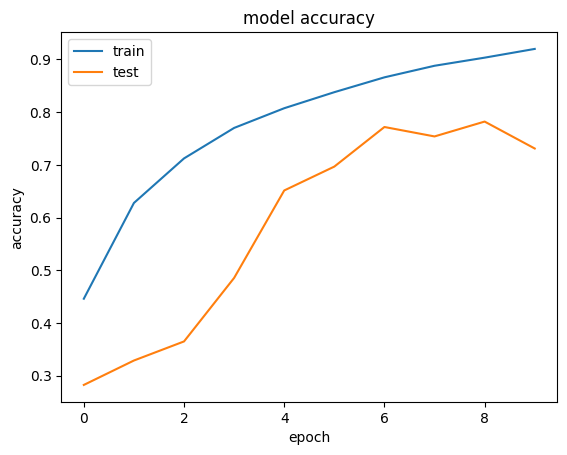

In [12]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.5323256850242615
0.8582376837730408


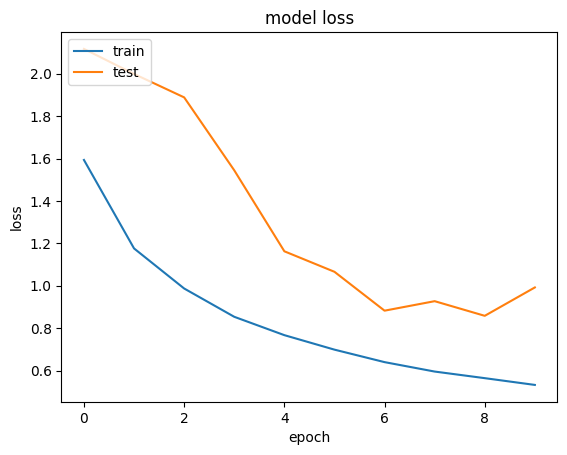

In [13]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))